In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import hdbscan

from ipywidgets import interact, IntSlider
import ipywidgets as widgets
widgets.IntSlider() 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # '3' to suppress warnings too


# Load Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')

Shape of x_train: (60000, 28, 28)
Shape of x_test: (10000, 28, 28)


[ 8412 43263 49199 40941 34464 21401  3320 57321]


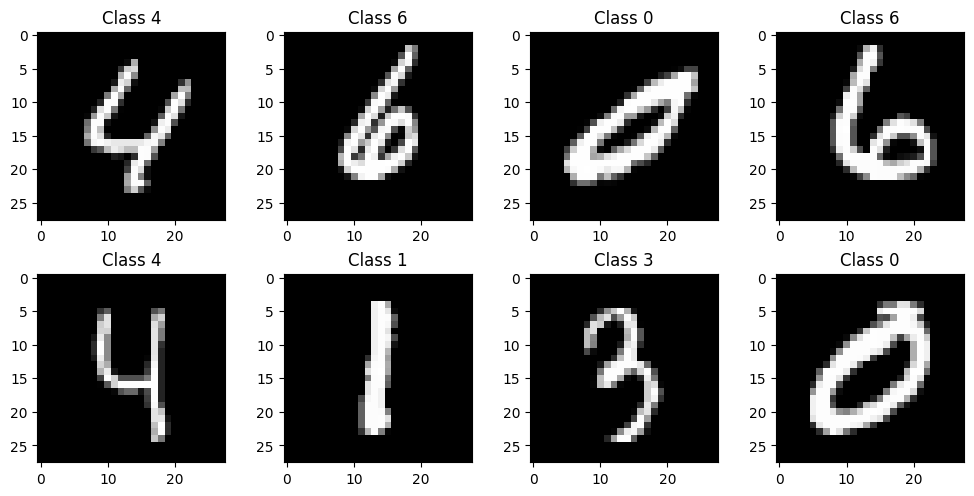

In [56]:
# show image of training data
plt.figure(figsize = (10, 5)) # set size of figure 10x10
rand_indexes = np.random.randint(0, x_train.shape[0], 8) # select 8 digits(0~9) randomly from the range 0 to x_train.shape[0] - 1
print(rand_indexes)

for index,im_index in enumerate(rand_indexes):
    plt.subplot(2, 4, index+1)
    plt.imshow(x_train[im_index], cmap = 'gray', interpolation = 'none')
    plt.title(f'Class {y_train[im_index]}' )
plt.tight_layout()

# GANs Model Structure

In [46]:
class Generator(tf.keras.Model):
    def __init__(self, z_dim=16):
        super(Generator, self).__init__()
        # From (batch, z_dim) to (batch, 7*7*16)
        self.dense1 = tf.keras.Sequential([
            layers.Dense(7 * 7 * 32, name = 'dense1'),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2)
            ], name = 'dense1_block')
        
        # From (batch, 7*7*32) to (batch, 7, 7, 32)
        self.reshape = layers.Reshape((7, 7, 32))
        
        # From (batch, 7, 7, 32) to (batch, 14, 14, 64)
        self.convT1 = tf.keras.Sequential([
            layers.Conv2DTranspose(64, (4, 4), strides = (2, 2), padding='same', name = 'convT1'),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2)
        ], name = 'convT1_block')

        # From (batch, 14, 14, 64) to (batch, 28, 28, 32)
        self.convT2 = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (4, 4), strides = (2, 2), padding='same', name = 'convT2'),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2)
        ], name = 'convT2_block')

        # From (batch, 28, 28, 32) to (batch, 28, 28, 1)
        self.convT3 = layers.Conv2DTranspose(1, (4, 4), activation='tanh', padding='same', name = 'convT3')

    def call(self, inputs, training = None):
        x = self.dense1(inputs, training=training)
        x = self.reshape(x)
        x = self.convT1(x, training = None)
        x = self.convT2(x, training = None)
        output = self.convT3(x)
        return output
    
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        # From (batch, 28, 28, 1) to (batch, 14, 14, 32)
        self.conv1 = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding = 'same', name = 'conv1'),
            layers.LeakyReLU(negative_slope=0.2),
            layers.SpatialDropout2D(rate=0.2),
            ], name = 'conv1_block')
        
        # From (batch, 14, 14, 32) to (batch, 7, 7, 64)
        self.conv2 = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), strides=(2, 2),  padding = 'same', name = 'conv2'),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.SpatialDropout2D(rate=0.3) ,
            ], name = 'conv2_block')
        
        # From (batch, 7, 7, 64) to (batch, 3, 3, 64)
        self.conv3 = tf.keras.Sequential([
            layers.Conv2D(64, (3, 3), strides=(2, 2),  padding = 'same', name = 'conv3'),
            layers.BatchNormalization(),
            layers.LeakyReLU(negative_slope=0.2),
            layers.SpatialDropout2D(rate=0.3) ,
            ], name = 'conv3_block')
        
        # From (batch, 3, 3, 64) to (batch, 3*3*64)
        self.flatten = layers.Flatten(name = 'flatten')

        # From (batch, 3, 3, 64) to (batch, 64)
        self.dense1 = layers.Dense(64, name = 'dense1', activation = 'relu')

        # From (batch, 7*7*64) to (batch, 1)
        self.dense2 = layers.Dense(1, name = 'output_dense', activation = 'sigmoid')

    def call(self, inputs, training = None):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)
        x = self.conv3(x, training=training)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output
    
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, z_dim = 16):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.z_dim = z_dim

        # Separate optimizers with different learning rates
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # Make it learn slower, so it doesn't overpower the generator:

        # Shared loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

        # Metrics
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")

    # The decorator is used to define a read-only attribute. 
    # TF will look at the metrics funcion to know which metrics it should track and display automatically during training. 
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    # compile() method is used to set optimizer, loss function, and metrics for the model.
    # Since we choose to manually manage optimizer, losses, and metrics, 
    # therefore we don't need to call the standard compile(optimizer = .., loss = .., metrics = ..) method.
    # But we need to overside compile()
    def compile(self, **kwargs):
        super(GAN, self).compile(**kwargs)
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        # Generate random noise
        noise = tf.random.normal(shape=(batch_size, self.z_dim))
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Discriminator predictions
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            # Calculate discriminator loss
            real_loss = self.loss_fn(tf.ones_like(real_predictions), real_predictions)
            fake_loss = self.loss_fn(tf.zeros_like(fake_predictions), fake_predictions)
            disc_loss = (real_loss + fake_loss) / 2
        
        # Calculate gradients and update discriminator
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as gen_tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Discriminator predictions for fake images
            fake_predictions = self.discriminator(generated_images, training=True)

            # Calculate generator loss
            gen_loss = self.loss_fn(tf.ones_like(fake_predictions), fake_predictions)

        # Calculate gradients and update generator
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Update metrics
        self.disc_loss_tracker.update_state(disc_loss)
        self.gen_loss_tracker.update_state(gen_loss)

        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result()
        }


def train_gan(gan, x_train, z_dim = 16, epochs = 10, batch_size = 128):
    """Training function with data preprocessing and monitoring"""
    # Normalize data to [-1, 1] range
    x_train = (x_train.astype('float32') - 127.5)/127.5
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

    # Training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        # Rest the metrics at the start of each epoch
        gan.gen_loss_tracker.reset_state()
        gan.disc_loss_tracker.reset_state()

        # Train on batches
        for batch in dataset:
            gan.train_step(batch)
        # Print metrics at the end of each epoch
        print(f'Gemerator Loss: {gan.gen_loss_tracker.result():.4f}, Discriminator Loss: {gan.disc_loss_tracker.result():.4f}')
        
        # Generate sample images every epoch
        generate_and_show_images(gan.generator, z_dim, epoch)

        for step, real_images in enumerate(dataset):
            metrics = gan.train_step(real_images)
            if step % 100 == 0:
                print(f'Step {step}, Gen Loss: {metrics["gen_loss"]:.4f}, Disc Loss: {metrics["disc_loss"]:.4f}')

def generate_and_show_images(generator, z_dim, epoch):
    """Generate and images from the generator"""
    noise = tf.random.normal(shape=(8, z_dim))
    generated_images = generator(noise, training = False)

    # Convert from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1)/2
    generated_images = generated_images.numpy()

    plt.figure(figsize=(32, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 8, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch + 1}')
    plt.show()


In [48]:
z_dim = 16
epochs = 20
batch_size = 128

# Initialize models
discriminator = Discriminator()
generator = Generator(z_dim)
gan = GAN(discriminator, generator, z_dim)

# Compile the GAN model
gan.generator(tf.random.normal((1, z_dim)))
gan.discriminator(tf.random.normal((1, 28, 28, 1)))

# Show the model summaries
gan.generator.summary()
gan.discriminator.summary()

Model: "generator_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense1_block (Sequential)       │ (1, 1568)              │        32,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (1, 7, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convT1_block (Sequential)       │ (1, 14, 14, 64)        │        33,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convT2_block (Sequential)       │ (1, 28, 28, 32)        │        32,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convT3 (Conv2DTranspose)        │ (1, 28, 28, 1)         │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,457 (388.50 KB)

 Trainable params: 96,129 (375.50 KB)

 Non-trainable params: 3,328 (13.00 KB)

Model: "discriminator_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_block (Sequential)        │ (1, 14, 14, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_block (Sequential)        │ (1, 7, 7, 64)          │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_block (Sequential)        │ (1, 4, 4, 64)          │        37,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 1024)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (1, 64)                │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (1, 1)                 │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,921 (476.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
Gemerator Loss: 1.8151, Discriminator Loss: 0.4392


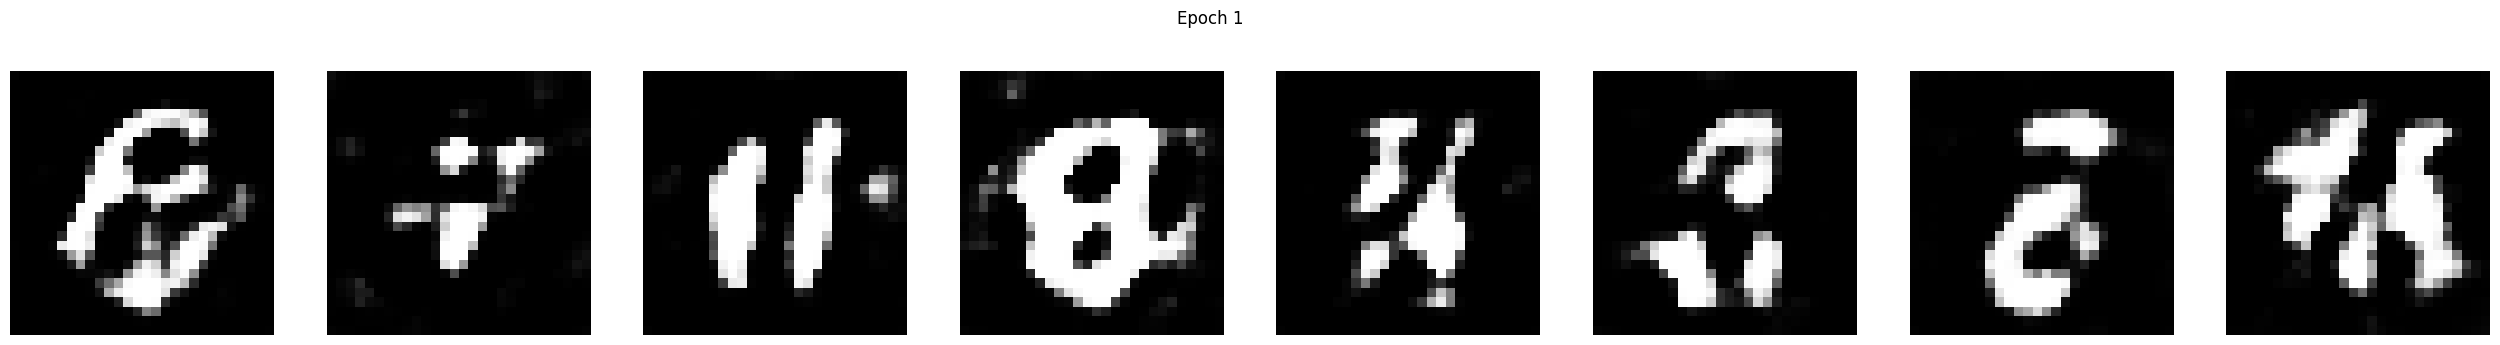

Step 0, Gen Loss: 1.8137, Disc Loss: 0.4394
Step 100, Gen Loss: 1.6986, Disc Loss: 0.4605
Step 200, Gen Loss: 1.6187, Disc Loss: 0.4740
Step 300, Gen Loss: 1.5633, Disc Loss: 0.4826
Step 400, Gen Loss: 1.5265, Disc Loss: 0.4876
Epoch 2/20
Gemerator Loss: 1.3555, Discriminator Loss: 0.5047


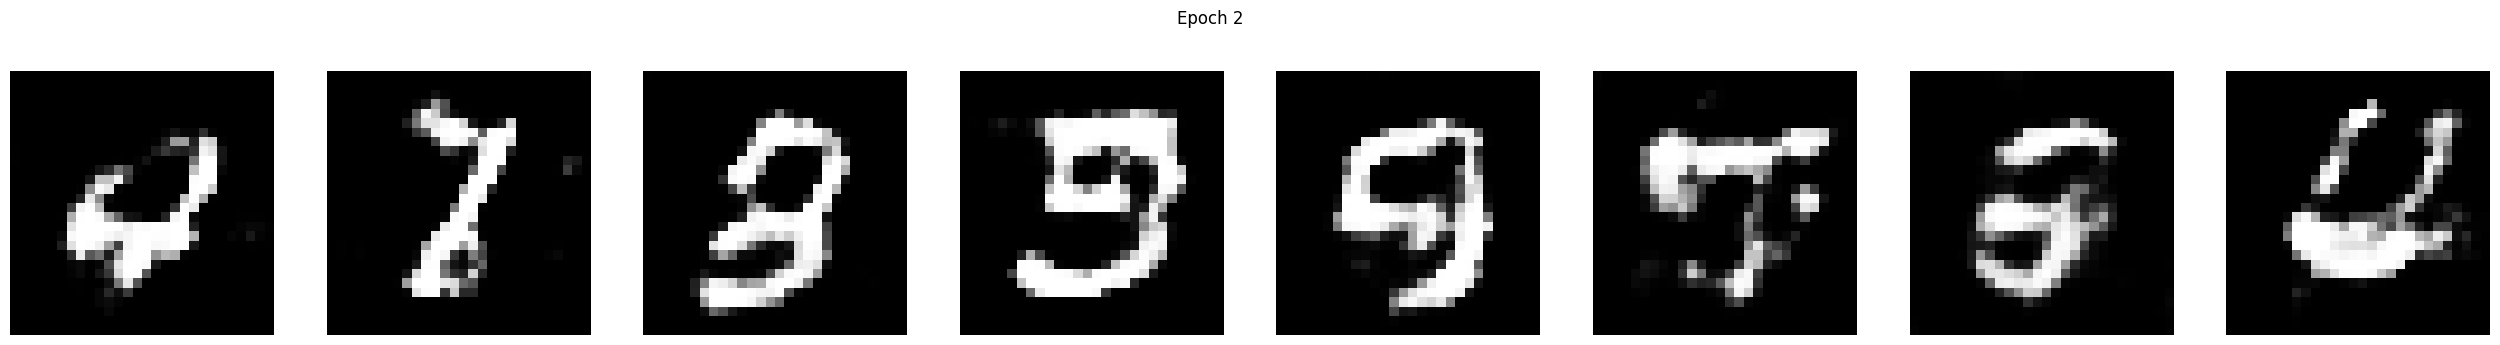

Step 0, Gen Loss: 1.3559, Disc Loss: 0.5047
Step 100, Gen Loss: 1.3581, Disc Loss: 0.5050
Step 200, Gen Loss: 1.3577, Disc Loss: 0.5044
Step 300, Gen Loss: 1.3548, Disc Loss: 0.5055
Step 400, Gen Loss: 1.3523, Disc Loss: 0.5065
Epoch 3/20
Gemerator Loss: 1.3083, Discriminator Loss: 0.5189


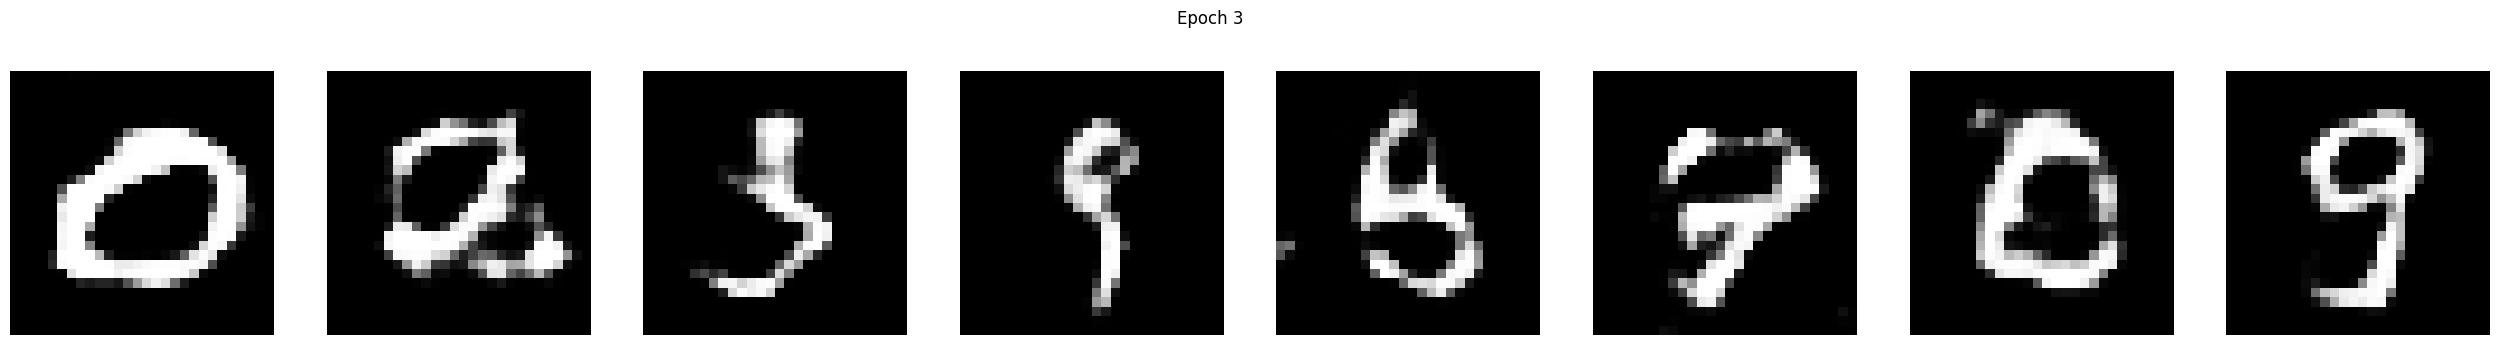

Step 0, Gen Loss: 1.3083, Disc Loss: 0.5188
Step 100, Gen Loss: 1.3088, Disc Loss: 0.5185
Step 200, Gen Loss: 1.3093, Disc Loss: 0.5191
Step 300, Gen Loss: 1.3053, Disc Loss: 0.5199
Step 400, Gen Loss: 1.3041, Disc Loss: 0.5201
Epoch 4/20
Gemerator Loss: 1.2884, Discriminator Loss: 0.5215


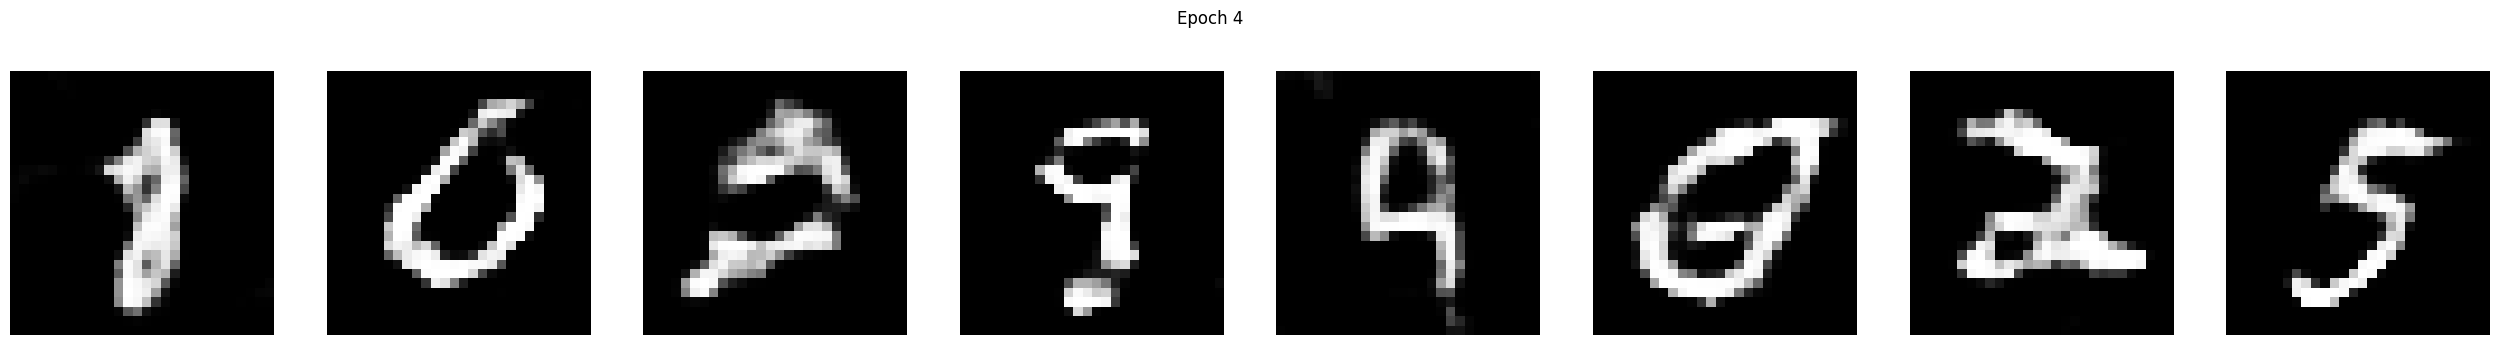

Step 0, Gen Loss: 1.2884, Disc Loss: 0.5215
Step 100, Gen Loss: 1.2848, Disc Loss: 0.5209
Step 200, Gen Loss: 1.2880, Disc Loss: 0.5208
Step 300, Gen Loss: 1.2899, Disc Loss: 0.5210
Step 400, Gen Loss: 1.2896, Disc Loss: 0.5198
Epoch 5/20
Gemerator Loss: 1.2735, Discriminator Loss: 0.5225


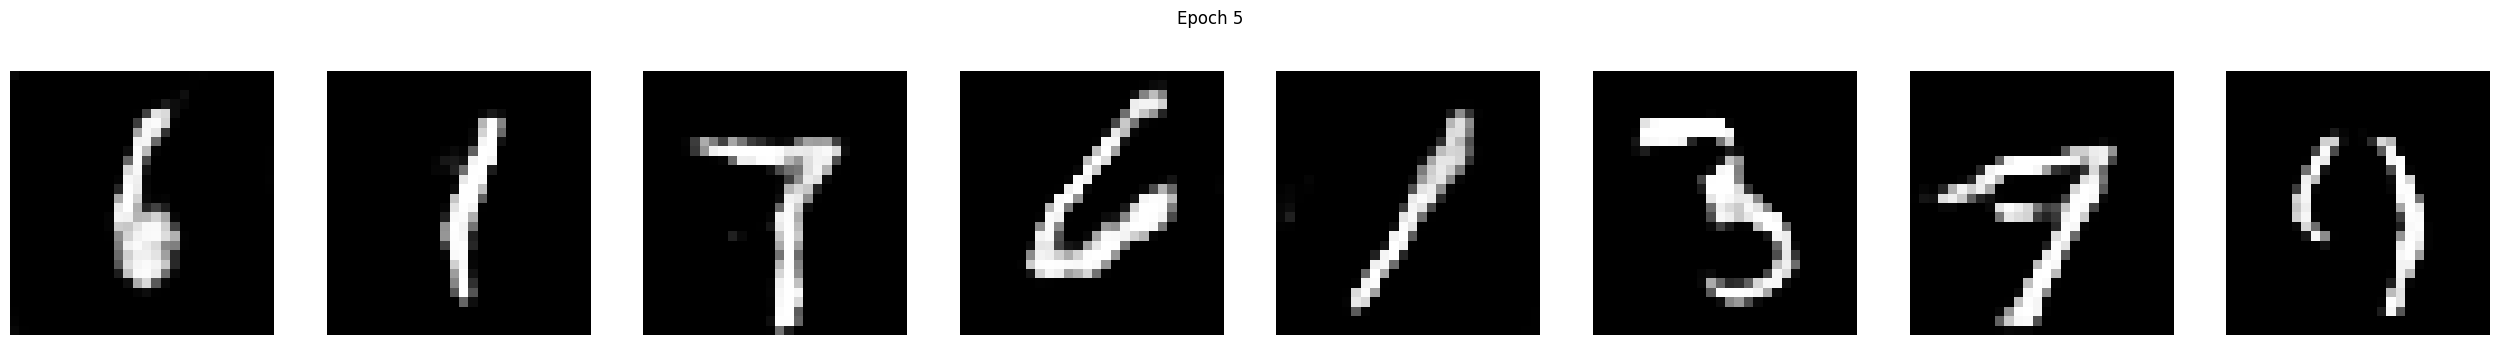

Step 0, Gen Loss: 1.2730, Disc Loss: 0.5225
Step 100, Gen Loss: 1.2755, Disc Loss: 0.5222
Step 200, Gen Loss: 1.2748, Disc Loss: 0.5225
Step 300, Gen Loss: 1.2778, Disc Loss: 0.5231
Step 400, Gen Loss: 1.2786, Disc Loss: 0.5229
Epoch 6/20
Gemerator Loss: 1.3014, Discriminator Loss: 0.5192


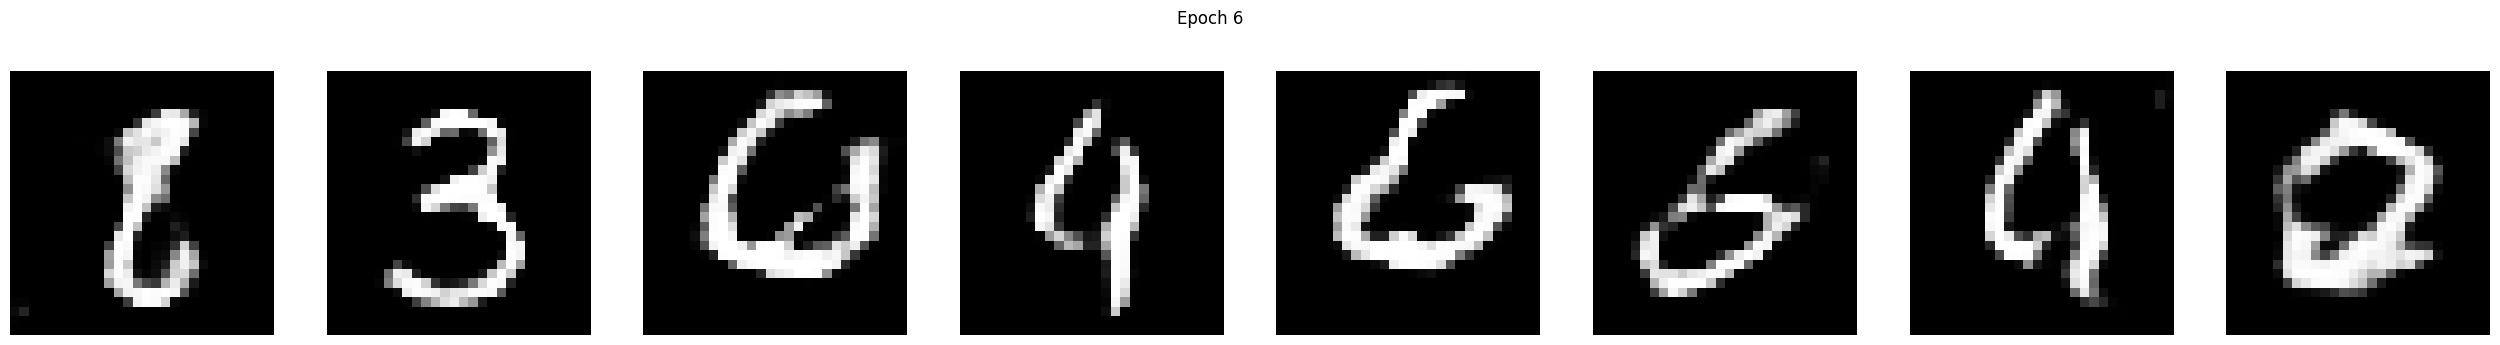

Step 0, Gen Loss: 1.3011, Disc Loss: 0.5192
Step 100, Gen Loss: 1.3038, Disc Loss: 0.5179
Step 200, Gen Loss: 1.3035, Disc Loss: 0.5177
Step 300, Gen Loss: 1.3020, Disc Loss: 0.5183
Step 400, Gen Loss: 1.3013, Disc Loss: 0.5191
Epoch 7/20
Gemerator Loss: 1.3054, Discriminator Loss: 0.5237


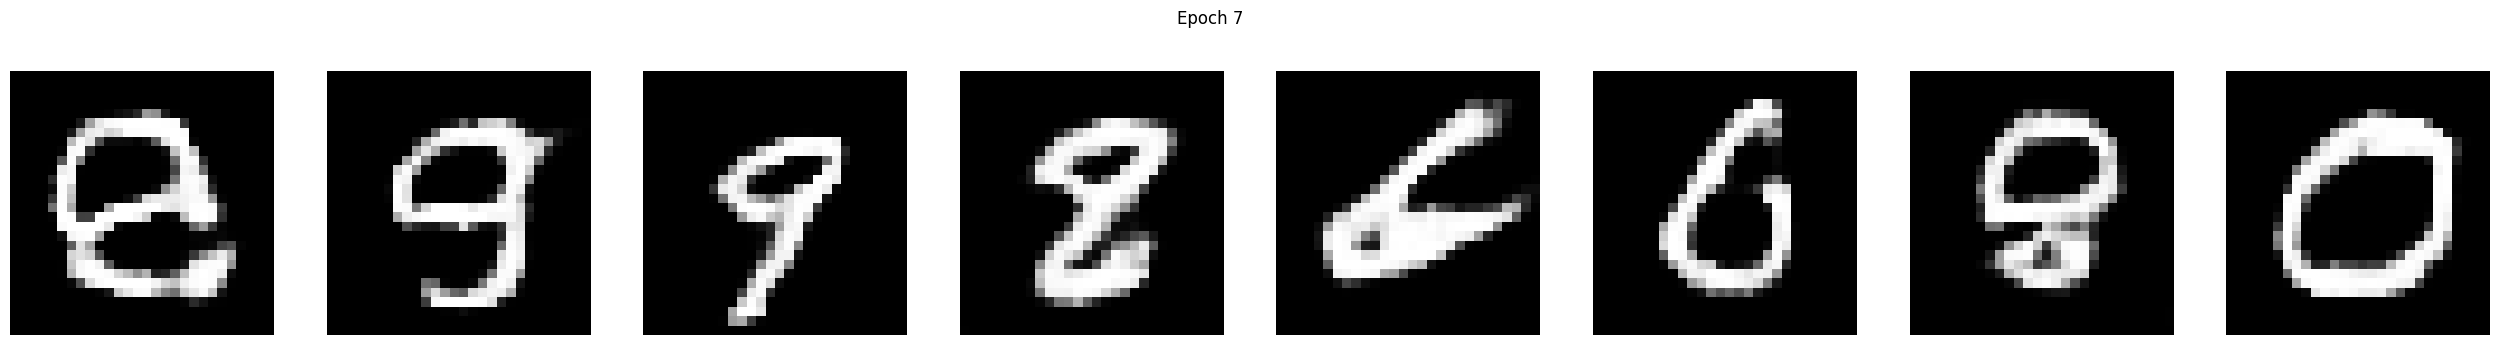

Step 0, Gen Loss: 1.3051, Disc Loss: 0.5235
Step 100, Gen Loss: 1.3046, Disc Loss: 0.5238
Step 200, Gen Loss: 1.3056, Disc Loss: 0.5237
Step 300, Gen Loss: 1.3050, Disc Loss: 0.5239
Step 400, Gen Loss: 1.3059, Disc Loss: 0.5237
Epoch 8/20
Gemerator Loss: 1.3202, Discriminator Loss: 0.5223


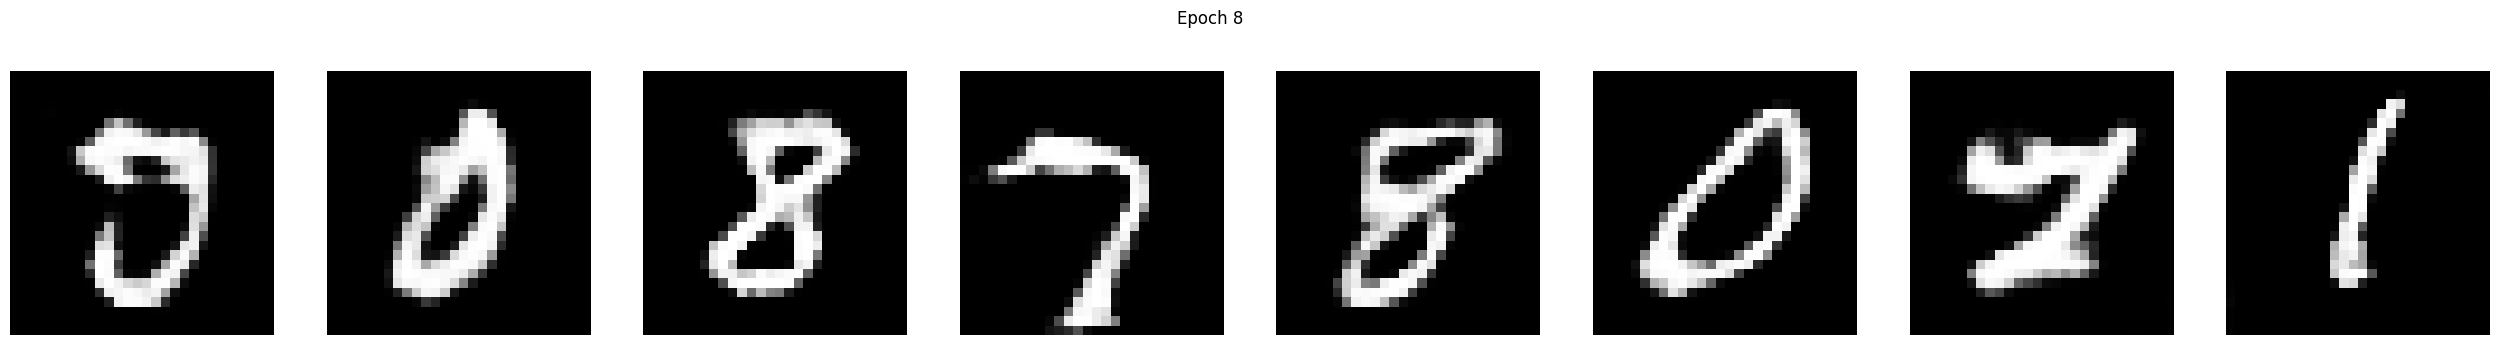

Step 0, Gen Loss: 1.3205, Disc Loss: 0.5221
Step 100, Gen Loss: 1.3201, Disc Loss: 0.5216
Step 200, Gen Loss: 1.3220, Disc Loss: 0.5219
Step 300, Gen Loss: 1.3206, Disc Loss: 0.5230
Step 400, Gen Loss: 1.3167, Disc Loss: 0.5224
Epoch 9/20
Gemerator Loss: 1.3278, Discriminator Loss: 0.5154


2025-06-05 17:39:25.002097: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


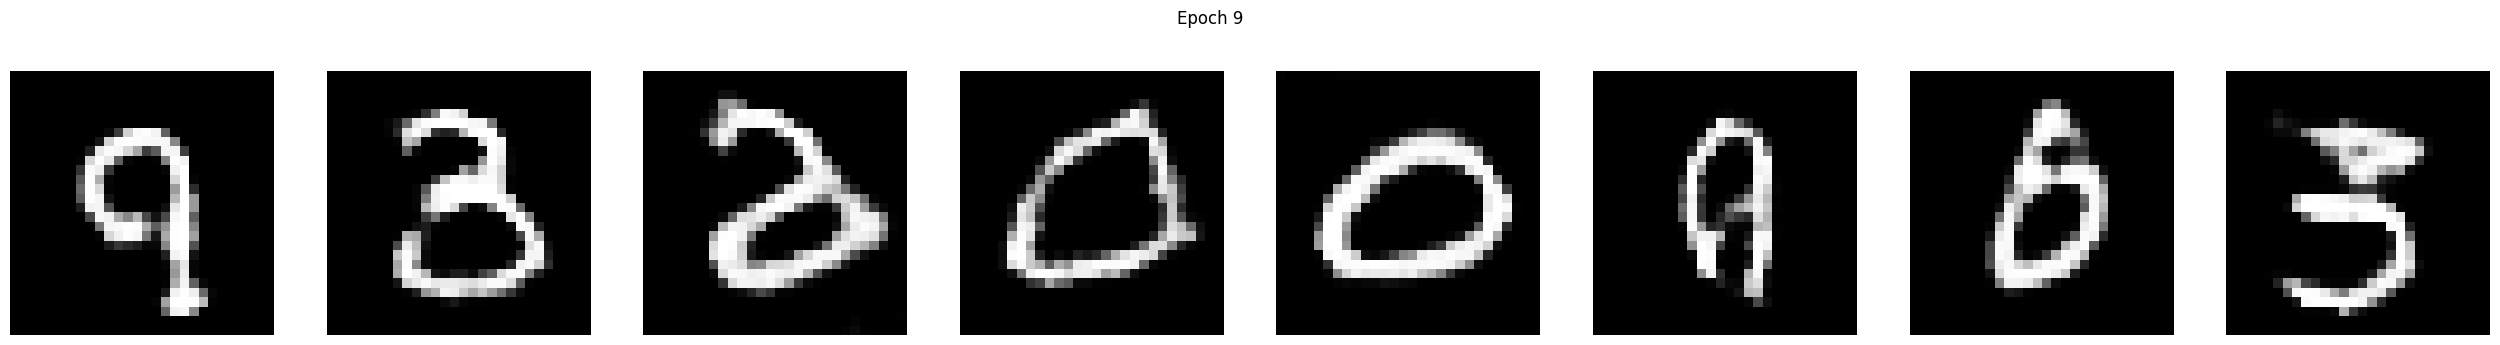

Step 0, Gen Loss: 1.3286, Disc Loss: 0.5156
Step 100, Gen Loss: 1.3323, Disc Loss: 0.5172
Step 200, Gen Loss: 1.3254, Disc Loss: 0.5189
Step 300, Gen Loss: 1.3207, Disc Loss: 0.5200
Step 400, Gen Loss: 1.3182, Disc Loss: 0.5211
Epoch 10/20
Gemerator Loss: 1.3245, Discriminator Loss: 0.5248


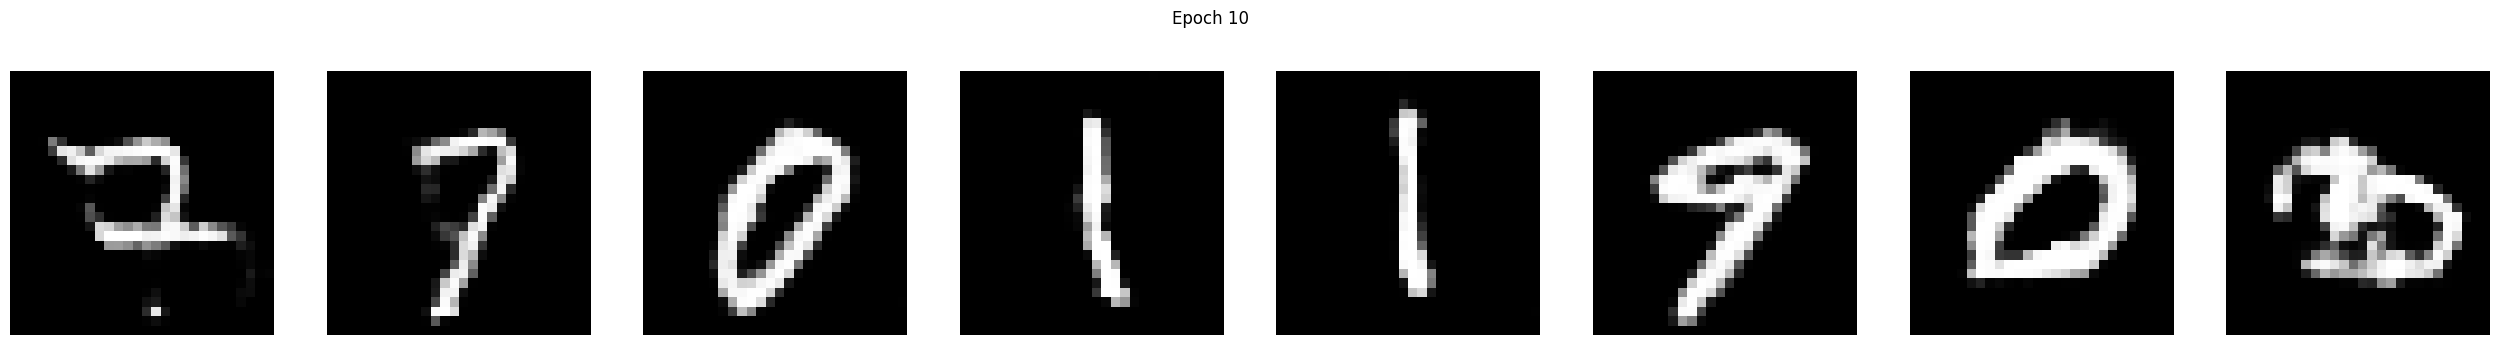

Step 0, Gen Loss: 1.3252, Disc Loss: 0.5247
Step 100, Gen Loss: 1.3185, Disc Loss: 0.5249
Step 200, Gen Loss: 1.3184, Disc Loss: 0.5240
Step 300, Gen Loss: 1.3194, Disc Loss: 0.5250
Step 400, Gen Loss: 1.3173, Disc Loss: 0.5258
Epoch 11/20
Gemerator Loss: 1.3224, Discriminator Loss: 0.5306


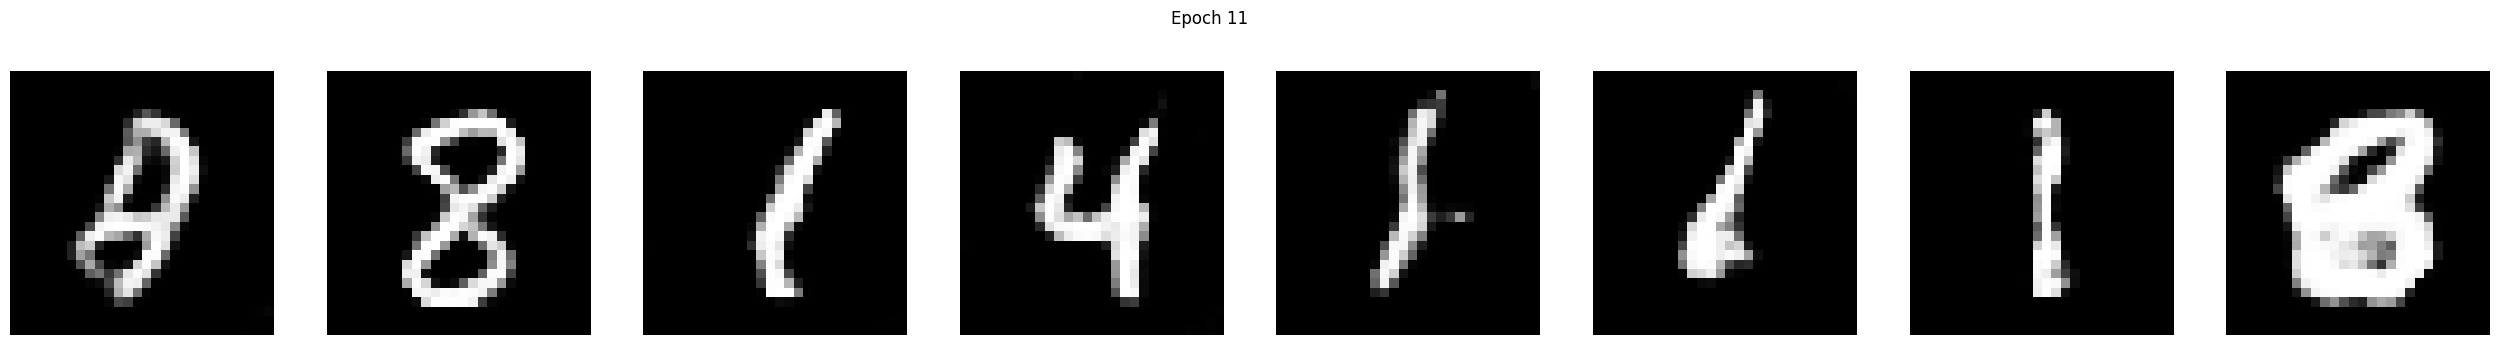

Step 0, Gen Loss: 1.3220, Disc Loss: 0.5305
Step 100, Gen Loss: 1.3205, Disc Loss: 0.5303
Step 200, Gen Loss: 1.3140, Disc Loss: 0.5297
Step 300, Gen Loss: 1.3145, Disc Loss: 0.5296
Step 400, Gen Loss: 1.3142, Disc Loss: 0.5295
Epoch 12/20
Gemerator Loss: 1.3164, Discriminator Loss: 0.5315


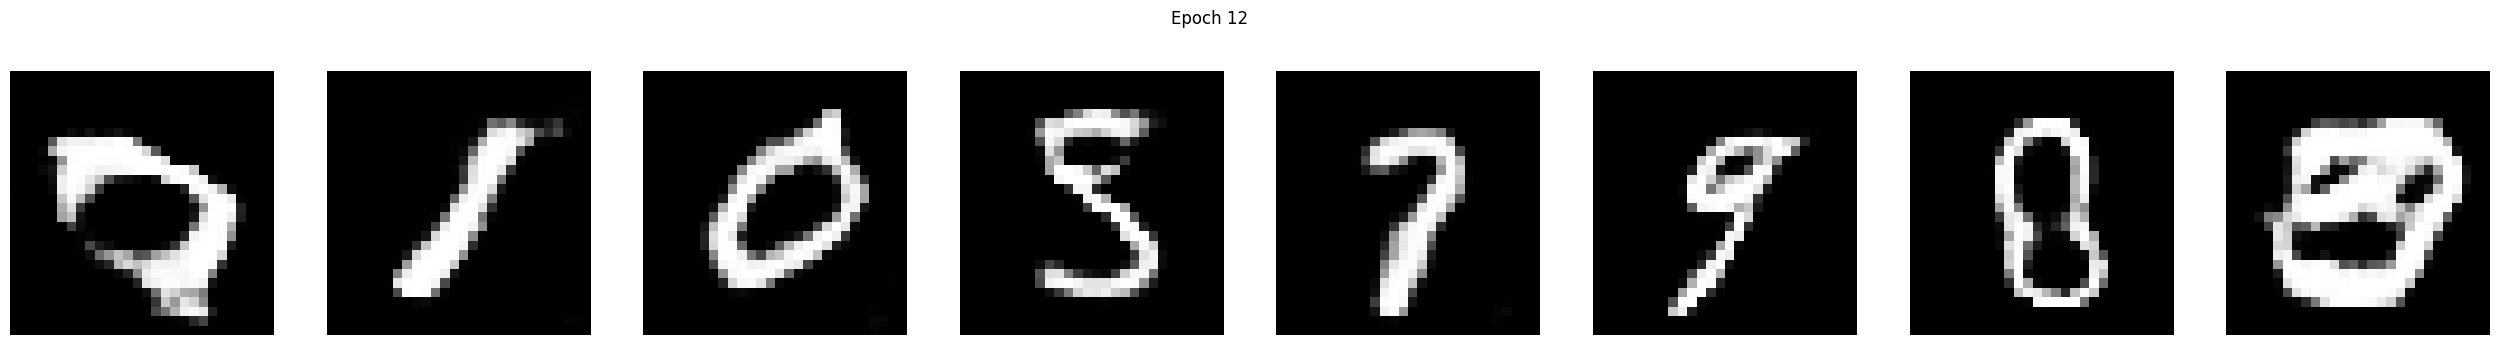

Step 0, Gen Loss: 1.3171, Disc Loss: 0.5314
Step 100, Gen Loss: 1.3026, Disc Loss: 0.5351
Step 200, Gen Loss: 1.3020, Disc Loss: 0.5340
Step 300, Gen Loss: 1.2987, Disc Loss: 0.5337
Step 400, Gen Loss: 1.2956, Disc Loss: 0.5303
Epoch 13/20
Gemerator Loss: 1.2948, Discriminator Loss: 0.5296


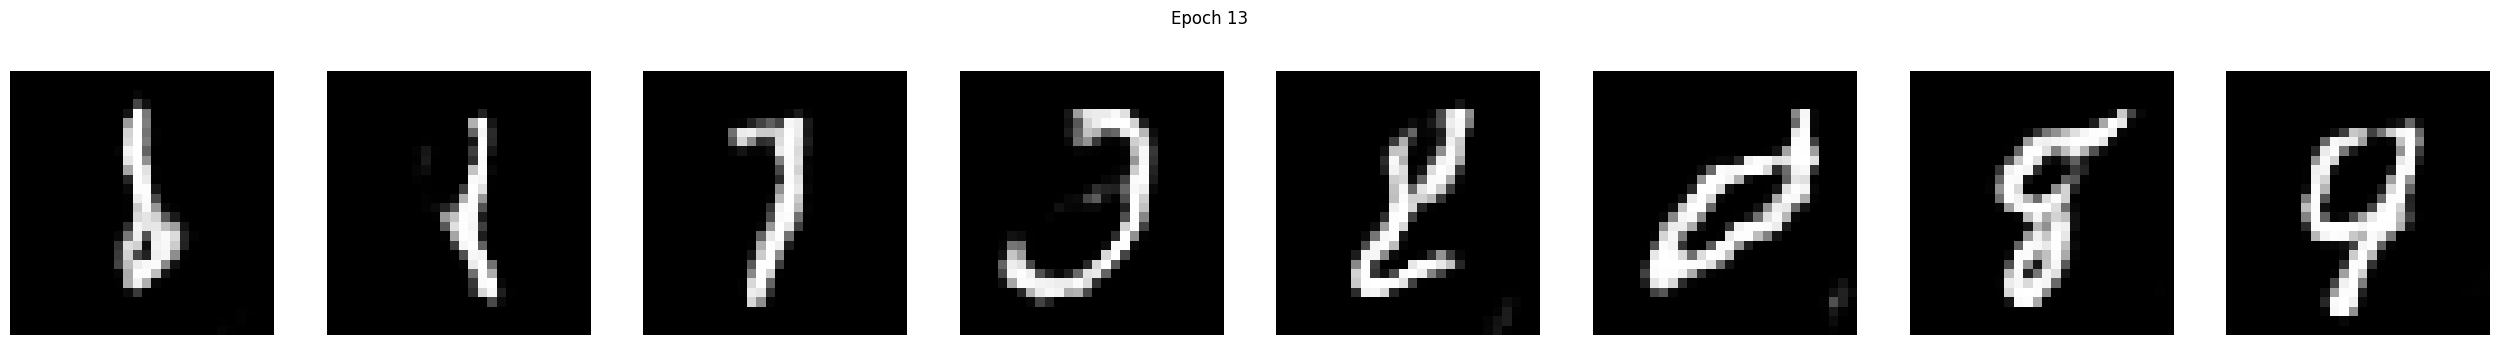

Step 0, Gen Loss: 1.2940, Disc Loss: 0.5296
Step 100, Gen Loss: 1.2938, Disc Loss: 0.5307
Step 200, Gen Loss: 1.2909, Disc Loss: 0.5312
Step 300, Gen Loss: 1.2911, Disc Loss: 0.5310
Step 400, Gen Loss: 1.2958, Disc Loss: 0.5316
Epoch 14/20
Gemerator Loss: 1.2882, Discriminator Loss: 0.5353


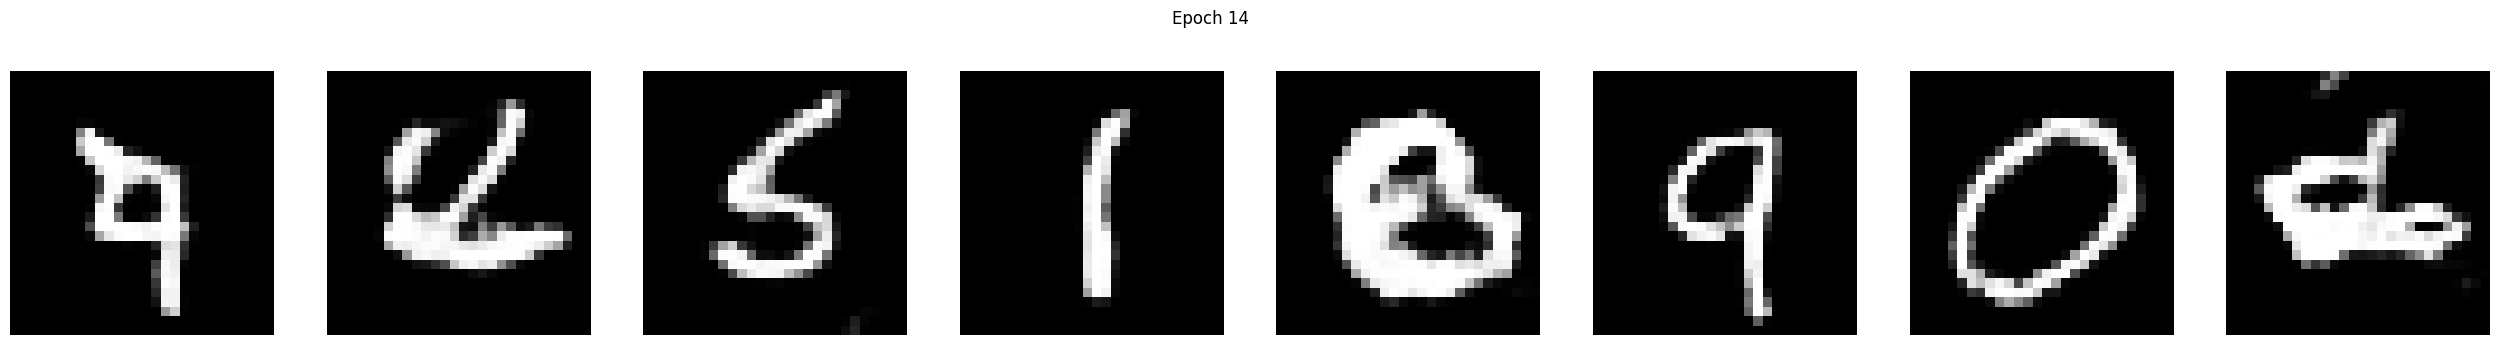

Step 0, Gen Loss: 1.2877, Disc Loss: 0.5352
Step 100, Gen Loss: 1.2897, Disc Loss: 0.5359
Step 200, Gen Loss: 1.2830, Disc Loss: 0.5356
Step 300, Gen Loss: 1.2825, Disc Loss: 0.5354
Step 400, Gen Loss: 1.2865, Disc Loss: 0.5360
Epoch 15/20
Gemerator Loss: 1.2928, Discriminator Loss: 0.5378


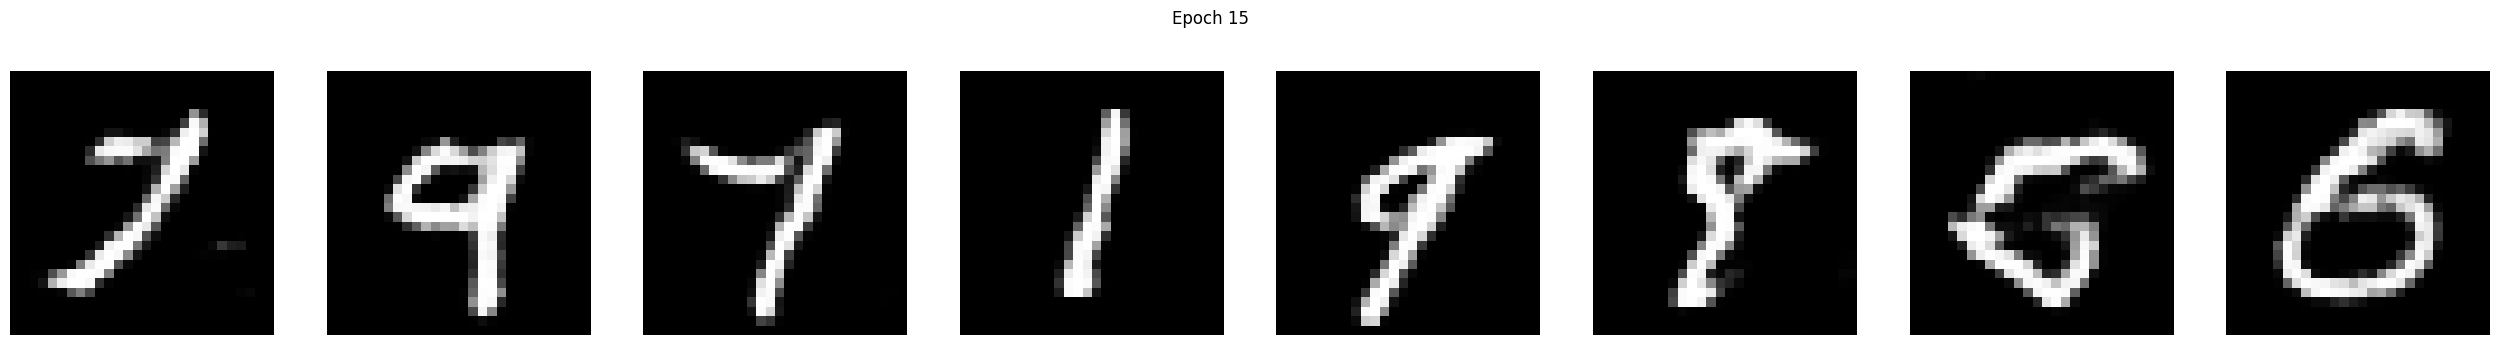

Step 0, Gen Loss: 1.2927, Disc Loss: 0.5375
Step 100, Gen Loss: 1.2946, Disc Loss: 0.5378
Step 200, Gen Loss: 1.2927, Disc Loss: 0.5376
Step 300, Gen Loss: 1.2912, Disc Loss: 0.5380
Step 400, Gen Loss: 1.2891, Disc Loss: 0.5388
Epoch 16/20
Gemerator Loss: 1.2798, Discriminator Loss: 0.5330


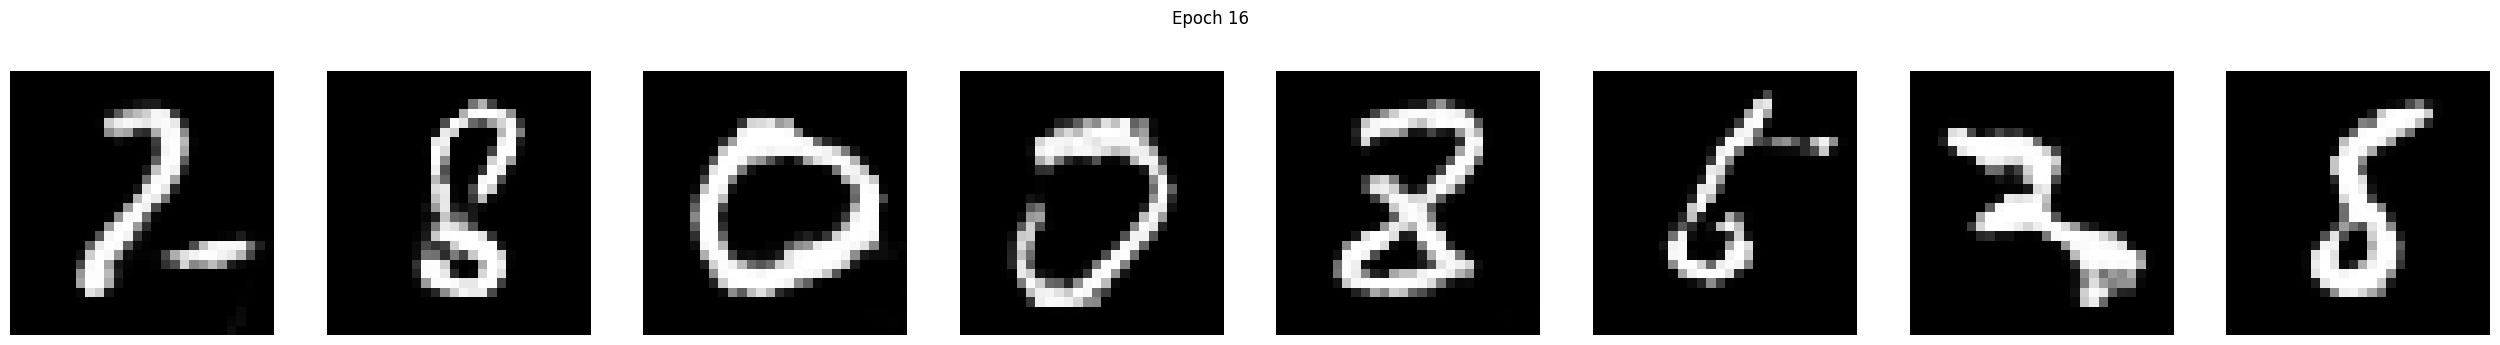

Step 0, Gen Loss: 1.2801, Disc Loss: 0.5330
Step 100, Gen Loss: 1.2824, Disc Loss: 0.5330
Step 200, Gen Loss: 1.2843, Disc Loss: 0.5325
Step 300, Gen Loss: 1.2957, Disc Loss: 0.5311
Step 400, Gen Loss: 1.2956, Disc Loss: 0.5316
Epoch 17/20
Gemerator Loss: 1.2918, Discriminator Loss: 0.5354


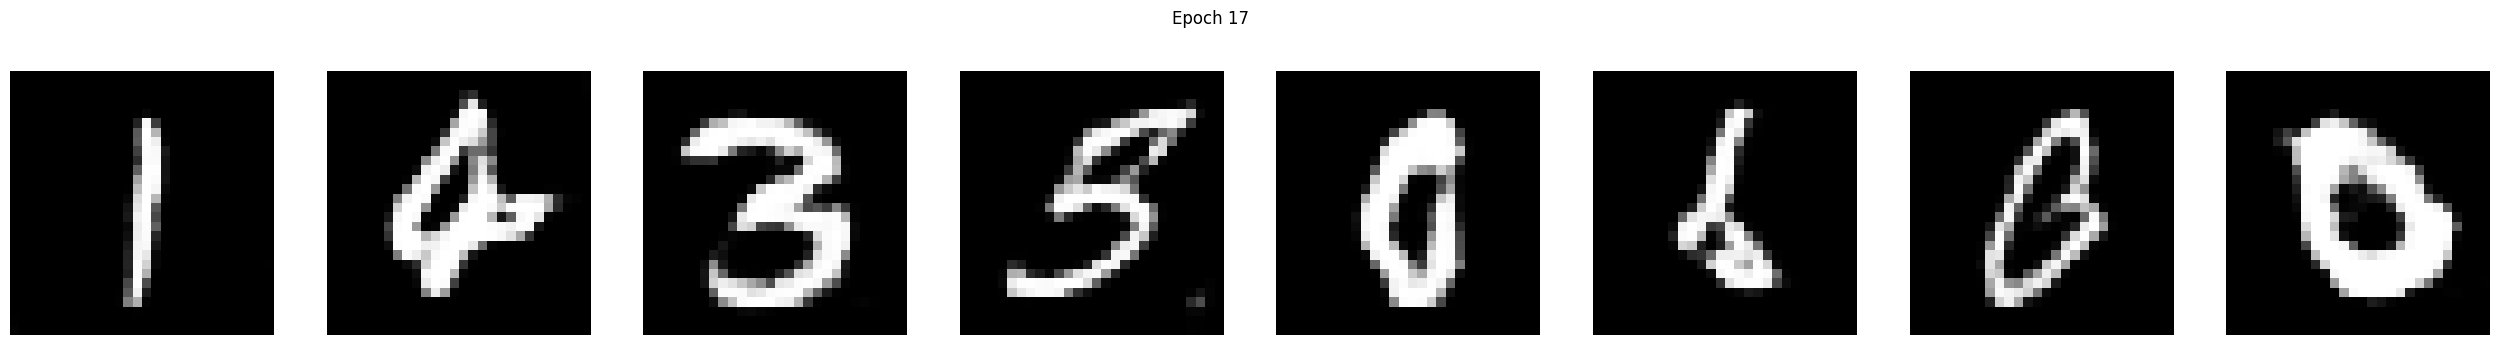

Step 0, Gen Loss: 1.2927, Disc Loss: 0.5352
Step 100, Gen Loss: 1.2928, Disc Loss: 0.5361
Step 200, Gen Loss: 1.2933, Disc Loss: 0.5365
Step 300, Gen Loss: 1.2911, Disc Loss: 0.5366
Step 400, Gen Loss: 1.2879, Disc Loss: 0.5352
Epoch 18/20
Gemerator Loss: 1.2955, Discriminator Loss: 0.5355


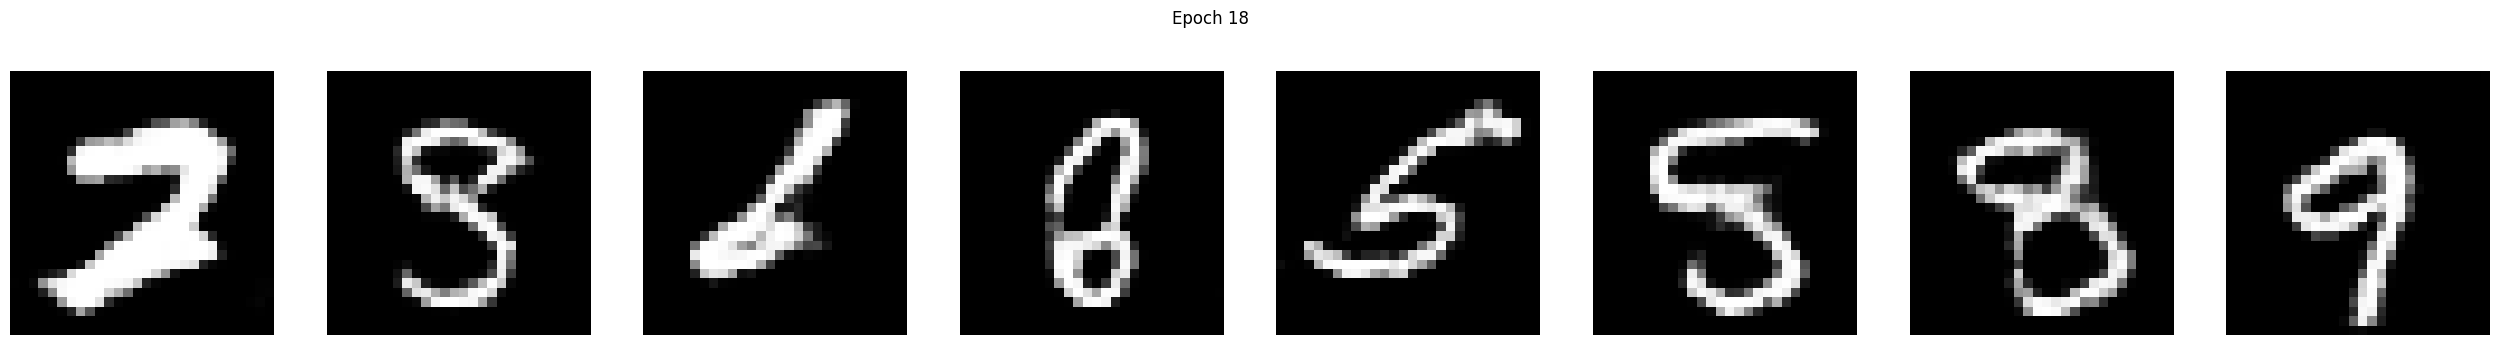

Step 0, Gen Loss: 1.2956, Disc Loss: 0.5354
Step 100, Gen Loss: 1.2951, Disc Loss: 0.5365
Step 200, Gen Loss: 1.2944, Disc Loss: 0.5362
Step 300, Gen Loss: 1.2902, Disc Loss: 0.5361
Step 400, Gen Loss: 1.2893, Disc Loss: 0.5358
Epoch 19/20
Gemerator Loss: 1.3012, Discriminator Loss: 0.5373


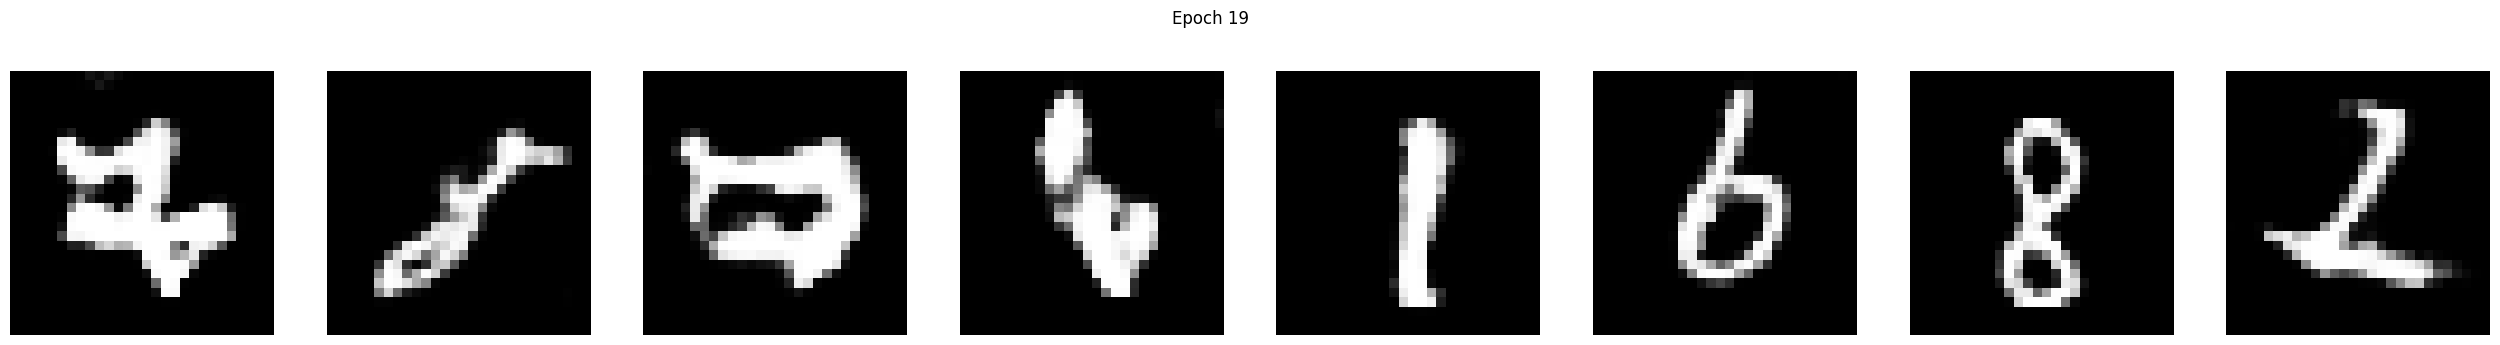

Step 0, Gen Loss: 1.3010, Disc Loss: 0.5372
Step 100, Gen Loss: 1.2959, Disc Loss: 0.5383
Step 200, Gen Loss: 1.3021, Disc Loss: 0.5371
Step 300, Gen Loss: 1.3017, Disc Loss: 0.5383
Step 400, Gen Loss: 1.3014, Disc Loss: 0.5387
Epoch 20/20
Gemerator Loss: 1.3187, Discriminator Loss: 0.5324


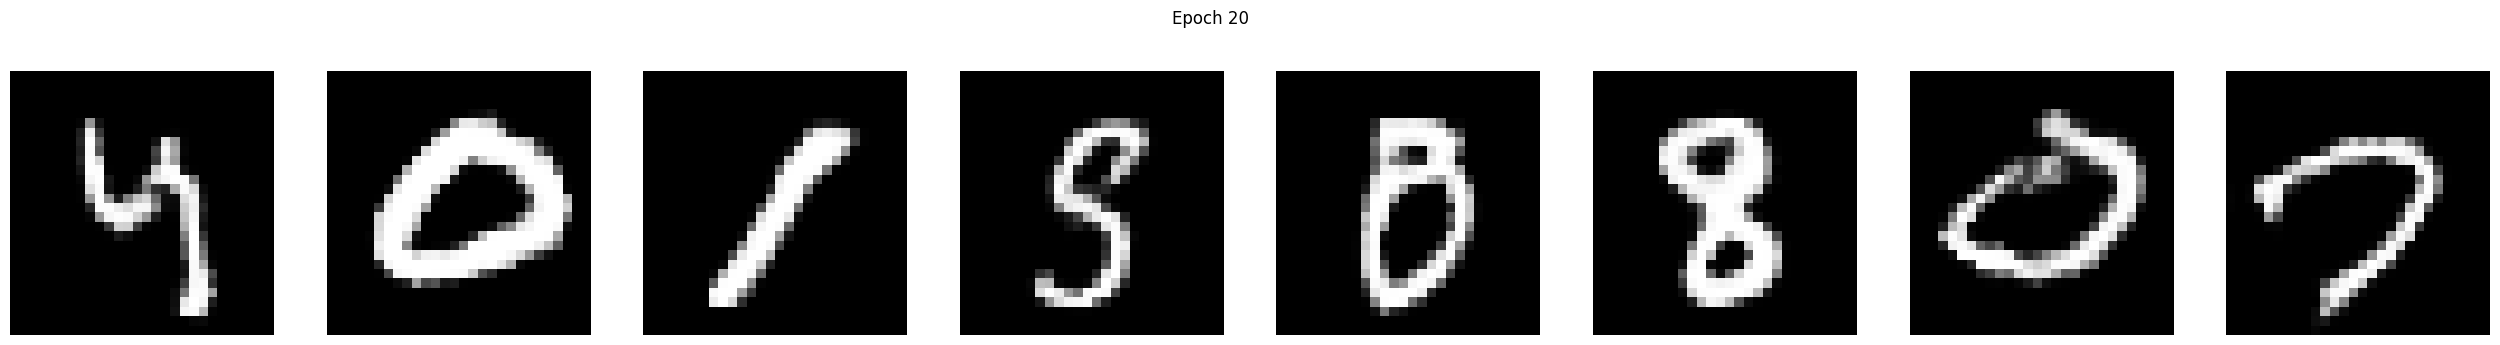

Step 0, Gen Loss: 1.3197, Disc Loss: 0.5326
Step 100, Gen Loss: 1.3174, Disc Loss: 0.5319
Step 200, Gen Loss: 1.3198, Disc Loss: 0.5337
Step 300, Gen Loss: 1.3116, Disc Loss: 0.5342
Step 400, Gen Loss: 1.3055, Disc Loss: 0.5337


In [49]:
train_gan(gan, x_train, z_dim, epochs, batch_size)

<span style="color: #FFA500;">
After only 10 epoches' training, the GAN model starts to generate decent hand written style digits!

We obverve Gen Loss is always higher than Disc Loss, this is normal as discriminator has an relatively easier task.

Both Gen Loss and Disc Loss did not change much during the training process. How can we evaluate whether our GAN training is good enough?

1. Visual quality: 
    * Are the generated images sharp, clear, and realistic? 
    * Are they diverse?
    * Do they look like real?

2. Gen and Disc balance:
    Both losses staying in a stable range (e.g., ca 0.6-1.2), and neither model dominating.


In [55]:
#
# Save the model
#
gan.generator.save("outputs/gan_mnist_generator_model.keras")
gan.discriminator.save("outputs/gan_mnist_discriminator_model.keras")

gan.generator.save_weights("outputs/gan_mnist_generator_model.weights.h5")
gan.discriminator.save_weights("outputs/gan_mnist_discriminator_model.weights.h5")

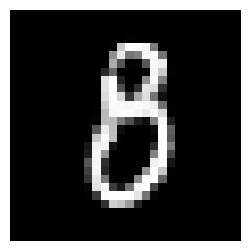

Discriminator result for the fake image: [[0.3446249]]


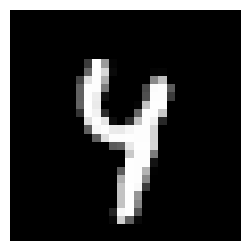

Discriminator result for the real image: [[0.]]


In [63]:
example = tf.random.normal(shape = (1, z_dim))
generated_image = gan.generator(example)
disc_result = gan.discriminator(generated_image)

rand_index = np.random.randint(0, x_train.shape[0])
real_image = x_train[rand_index]
disc_real_result = gan.discriminator(tf.expand_dims(real_image, axis=0))
def show_image(image):
    """Display a single image"""
    image = tf.reshape(image, (28, 28))  # Reshape to 2D
    plt.figure(figsize=(3, 3))  # Set size of figure 5x5
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Show a generated image
show_image(generated_image)
print(f'Discriminator result for the fake image: {disc_result.numpy()}')
# Show a real image
show_image(real_image)
print(f'Discriminator result for the real image: {disc_real_result.numpy()}')

<span style="color:#FFA500;">
It seems the discriminator is not very good at distinguishing real from fake images, we need more training epochs or a more complex model. But so far it is good. Let's next try different methods to improve the GAN model
</span>

# Try methods to improve the GAN model

## Use W-Loss and 1-L Enforcement (Gradient Penalty)

In [ ]:
def w_loss_and_gradient_penalty(real_images, generated_images, critic, is_critic = None, lambda_gp=10.0):
    """Calculate Wasserstein loss and gradient penalty"""
    # Calculate discriminator predictions
    real_predictions = critic(real_images, training=True)
    fake_predictions = critic(generated_images, training=True)
    # Calculate Wasserstein loss
    critic_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
    generator_loss = -tf.reduce_mean(fake_predictions)
    # Calculate gradient penalty
    alpha = tf.random.uniform(shape=(tf.shape(real_images)[0], 1, 1, 1), minval=0.0, maxval=1.0)
    interpolated_images = alpha * real_images + (1 - alpha) * generated_images
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        interpolated_predictions = critic(interpolated_images, training=True)
    gradients = tape.gradient(interpolated_predictions, interpolated_images)
    gradients = tf.reshape(gradients, (tf.shape(gradients)[0], -1))
    gradient_norm = tf.norm(gradients, axis=1)
    gradient_penalty = tf.reduce_mean((gradient_norm - 1.0)**2)
    # Combine W loss and gradient penalty
    if is_critic:
        total_loss = critic_loss + lambda_gp * gradient_penalty
    else:
        total_loss = generator_loss
    return total_loss, gradient_penalty


class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, z_dim = 16):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.z_dim = z_dim

        # Separate optimizers with different learning rates
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # Make it learn slower, so it doesn't overpower the generator:

        # # Shared loss function
        # self.loss_fn = tf.keras.losses.BinaryCrossentropy()

        # Metrics
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")

    # The decorator is used to define a read-only attribute. 
    # TF will look at the metrics funcion to know which metrics it should track and display automatically during training. 
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    # compile() method is used to set optimizer, loss function, and metrics for the model.
    # Since we choose to manually manage optimizer, losses, and metrics, 
    # therefore we don't need to call the standard compile(optimizer = .., loss = .., metrics = ..) method.
    # But we need to overside compile()
    def compile(self, **kwargs):
        super(GAN, self).compile(**kwargs)
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        # Generate random noise
        noise = tf.random.normal(shape=(batch_size, self.z_dim))
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Discriminator predictions
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            # Calculate discriminator loss
            real_loss = self.loss_fn(tf.ones_like(real_predictions), real_predictions)
            fake_loss = self.loss_fn(tf.zeros_like(fake_predictions), fake_predictions)
            disc_loss = (real_loss + fake_loss) / 2
        
        # Calculate gradients and update discriminator
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as gen_tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Discriminator predictions for fake images
            fake_predictions = self.discriminator(generated_images, training=True)

            # Calculate generator loss
            gen_loss = w_loss_and_gradient_penalty(real_images, generated_images, critic = self.discriminator, lambda_gp=10.0)

        # Calculate gradients and update generator
        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        # Update metrics
        self.disc_loss_tracker.update_state(disc_loss)
        self.gen_loss_tracker.update_state(gen_loss)

        return {
            "gen_loss": self.gen_loss_tracker.result(),
            "disc_loss": self.disc_loss_tracker.result()
        }


def train_gan(gan, x_train, z_dim = 16, epochs = 10, batch_size = 128):
    """Training function with data preprocessing and monitoring"""
    # Normalize data to [-1, 1] range
    x_train = (x_train.astype('float32') - 127.5)/127.5
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices(x_train)
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

    # Training loop
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        # Rest the metrics at the start of each epoch
        gan.gen_loss_tracker.reset_state()
        gan.disc_loss_tracker.reset_state()

        # Train on batches
        for batch in dataset:
            gan.train_step(batch)
        # Print metrics at the end of each epoch
        print(f'Gemerator Loss: {gan.gen_loss_tracker.result():.4f}, Discriminator Loss: {gan.disc_loss_tracker.result():.4f}')
        
        # Generate sample images every epoch
        generate_and_show_images(gan.generator, z_dim, epoch)

        for step, real_images in enumerate(dataset):
            metrics = gan.train_step(real_images)
            if step % 100 == 0:
                print(f'Step {step}, Gen Loss: {metrics["gen_loss"]:.4f}, Disc Loss: {metrics["disc_loss"]:.4f}')